# Consumer Reviews Data Analysis

## Notebook Setup

In [1]:
# check available RAM
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        865M         22G        1.2M        2.5G         24G
Swap:            0B          0B          0B


In [2]:
# data source: http://deepyeti.ucsd.edu/jianmo/amazon/index.html
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download(['vader_lexicon','stopwords'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Product Data

### Data Initialization

In [73]:
# get products data
dfProd = pd.read_json('gdrive/MyDrive/amazon_data/meta_Video_Games.json', lines=True)

In [50]:
print(dfProd.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [51]:
print(dfProd.head())

                                            category tech1  \
0                           [Video Games, PC, Games]         
1  [Video Games, Xbox 360, Games, </span></span><...         
2  [Video Games, Retro Gaming & Microconsoles, Su...         
3  [Video Games, Xbox 360, Accessories, Controlle...         
4  [Video Games, PC, Games, </span></span></span>...         

                                         description fit  \
0                                                 []       
1                                [Brand new sealed!]       
2                                                 []       
3  [MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...       
4  [Phonics Alive! 3, The Speller teaches student...       

                                               title      also_buy tech2  \
0                         Reversi Sensory Challenger            []         
1  Medal of Honor: Warfighter - Includes Battlefi...  [B00PADROYW]         
2  street fighter 2 II turbo super nin

### Data Cleaning

In [74]:
# drop duplicates
dfProdDup = dfProd.loc[dfProd.duplicated(['asin'])]
dfProdDup = dfProd.loc[dfProd['asin'].isin(list(dfProdDup['asin']))]
dfProdDup = dfProdDup.sort_values(by='asin')

dfProd = dfProd.drop_duplicates(['asin'], ignore_index=True)

#### Rank

In [75]:
dfProd['rank'] = dfProd['rank'].apply(lambda x: [x] if len(x) > 4 else x)

def rank_mod(s):
  res = [ss.replace(',', '').replace('&amp;', '&').replace('\n', '').replace('\t', '').replace('\\', '').replace('#',
             '').replace('&gt;', '>').lstrip('>').rstrip(' (') for ss in s]
  res = [re.sub(" ([\(\[]).*?([\)\]])", "", r) for r in res]
  res = sorted(res, key=lambda x: x.count('>'))

  res = [item.split(' in ', 1) for item in res]
  res = [item for l in res for item in l]

  return res

dfProd['rank'] = dfProd['rank'].apply(lambda x: rank_mod(x))


In [76]:
dfProdRank = pd.DataFrame(dfProd['rank'].to_list(), columns=['rank1', 'category1', 'rank2', 'category2',
                                                              'rank3', 'category3', 'rank4', 'category4'])

In [77]:
dfProdRank = dfProdRank.merge(dfProd, left_index=True, right_index=True)
dfProdRank = dfProdRank[['rank1', 'category1', 'rank2', 'category2', 'rank3', 'category3', 'rank4', 'category4',
                         'asin', 'title', 'main_cat', 'category']]

In [78]:
dfProdRank = dfProdRank.loc[dfProdRank['category1'].notna()]
dfProdRank['category1'] = dfProdRank.category1.str.replace(r'^Video Games.*', 'Video Games', regex=True)
dfProdRank['category'] = [','.join(map(str, l)) for l in dfProdRank['category']]

# only use the products that have a BSR in category Video Games, for easier comparison amongst video game products
dfProdRank = dfProdRank.loc[dfProdRank['category1'] == 'Video Games']

# remove irrelevant products like accessories
dfProdRank = dfProdRank.loc[(dfProdRank['main_cat'].isin(['Video Games', 'Sports & Outdoors', ''])) & 
                              (~dfProdRank['category'].str.contains('accessories', case=False))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
# merge rank info into original product data
dfProd = dfProd.merge(dfProdRank, how='inner', on='asin', suffixes=('', '_y'))

#### Brand

In [80]:
dfProd['brand'] = dfProd['brand'].str.replace('by\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('by ', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.lstrip()

In [81]:
dfProd = dfProd.replace({'EA': 'Electronic Arts', 'EA Games': 'Electronic Arts', 'At Electronic Arts': 'Electronic Arts',
                         'Electronic Arts Sports': 'EA Sports', 'Electronic Arts, Inc.': 'Electronic Arts',
                         'Electronic Arts Inc.': 'Electronic Arts', 'Electronic Arts 1001573': 'EA Sports',
                         'EA Active': 'EA Sports', 'Electronic Arts UK IMPORT': 'EA Sports'})
dfProd = dfProd.replace({'HPS Simulation': 'HPS Simulations'})
dfProd = dfProd.replace({'PS1': 'Playstation', 'PS2': 'Playstation', 'PS3': 'Playstation', 'PS4': 'Playstation'})
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS4.*$)', 'Playstation', regex=True)

# dfProd = dfProd.replace({'': None, 'Unknown': None})

In [ ]:
dfProd[['brand', 'title']].loc[dfProd['brand'].str.contains('xbox', case=False)].sort_values(by='brand')

In [9]:
dfProdBrand = dfProd['brand'].value_counts(dropna=False).reset_index()
dfProdBrand

#### Others

In [180]:
# clean date
# dfProd['date'] = dfProd['date'].replace({'.*div.*': np.nan, '83001177': np.nan, 'Creazydog': np.nan}, regex=True)
# dfProd['date'] = pd.to_datetime(dfProd['date'])

In [82]:
# convert price to float dtype
def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan
dfProd['price'] = dfProd['price'].str.replace('$', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(',', '', regex=True)
dfProd['price'] = dfProd['price'].replace({'': np.nan})
dfProd['price'] = dfProd['price'].apply(lambda p: convert_float(p))

### Data Manipulation

In [83]:
# count number of images & high resolution images
dfProd['numImages'] = dfProd['imageURL'].str.len()
dfProd['numHighResImages'] = dfProd['imageURLHighRes'].str.len()

In [ ]:
dfProd['feature'] = [','.join(map(str, l)) for l in dfProd['feature']]

In [89]:
dfProd['description'] = [','.join(map(str, l)) for l in dfProd['description']]

In [ ]:
# dfProd['details'] = dfProd['details'].fillna({})
# dfProd['details'] = [list(d.keys()) for d in dfProd['details']]
# dfProd['details'] = [','.join(map(str, l)) for l in dfProd['details']]
# dfProd['details'].unique()

In [97]:
# final touch-up
dfProd = dfProd.astype({'numImages': np.uint8, 'numHighResImages': np.uint8})
dfProd = dfProd[['asin', 'title', 'brand', 'category_y', 'price', #'category', 
                 'rank1', 'rank2', 'category2', 'rank3', 'category3', 'rank4', 'category4',
                 'numImages', 'numHighResImages',
                 'main_cat', 'details', 'feature'#, 'also_buy', 'also_view', 'similar_item' #'description'
                 ]]

In [98]:
dfProd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40943 entries, 0 to 40942
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   asin              40943 non-null  object 
 1   title             40943 non-null  object 
 2   brand             40943 non-null  object 
 3   category_y        40943 non-null  object 
 4   price             6856 non-null   float64
 5   rank1             40943 non-null  object 
 6   rank2             38639 non-null  object 
 7   category2         38639 non-null  object 
 8   rank3             8388 non-null   object 
 9   category3         8388 non-null   object 
 10  rank4             5375 non-null   object 
 11  category4         5375 non-null   object 
 12  numImages         40943 non-null  uint8  
 13  numHighResImages  40943 non-null  uint8  
 14  main_cat          40943 non-null  object 
 15  details           40867 non-null  object 
 16  feature           40943 non-null  object

In [100]:
dfProd.describe(include='all')

,asin,title,brand,category_y,price,rank1,rank2,category2,rank3,category3,rank4,category4,numImages,numHighResImages,main_cat,details,feature
count,40943,40943,40943,40943,6856.000000,40943,38639,38639,8388,8388,5375,5375,40943.000000,40943.000000,40943,40867,40943
unique,40943,38860,3742,8069,NaN,35611,12237,168,4812,150,4155,79,NaN,NaN,3,61,23917
top,0078764343,NBA 2K15 - PlayStation 4,Electronic Arts,"Video Games,PC,Games,</span></span></span>",NaN,3422,1,Video Games > PC Games > PC Games,7,Video Games > PC Games > Digital Games & DLC,27,Video Games > PC Games > PC Games,NaN,NaN,Video Games,{},
freq,1,9,2422,6704,NaN,8,55,7933,16,3620,8,3588,NaN,NaN,40897,40804,11541
mean,NaN,NaN,NaN,NaN,51.385702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.020492,3.020492,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,81.081829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.076086,3.076086,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,13.987500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,27.285000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,55.802500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,NaN,NaN,NaN


### Plots

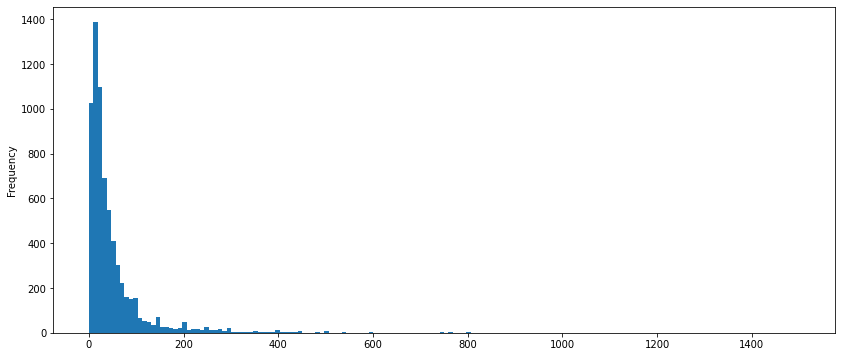

In [101]:
dfProd['price'].plot.hist(bins=160, figsize=(14,6))

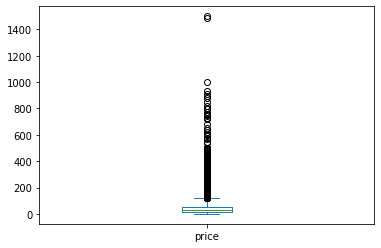

In [102]:
dfProd['price'].plot.box()

## Reviews Data

### Initial Data

In [4]:
# get reviews data
dfReviews = pd.read_json("gdrive/MyDrive/amazon_data/Video_Games.json", lines=True)

In [5]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         2565349 non-null  int64 
 1   verified        2565349 non-null  bool  
 2   reviewTime      2565349 non-null  object
 3   reviewerID      2565349 non-null  object
 4   asin            2565349 non-null  object
 5   reviewerName    2565096 non-null  object
 6   reviewText      2563634 non-null  object
 7   summary         2564538 non-null  object
 8   unixReviewTime  2565349 non-null  int64 
 9   vote            442716 non-null   object
 10  style           1319972 non-null  object
 11  image           28305 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 217.7+ MB
None


In [6]:
print(dfReviews.describe())

            overall  unixReviewTime
count  2.565349e+06    2.565349e+06
mean   4.022095e+00    1.388666e+09
std    1.405936e+00    1.159381e+08
min    1.000000e+00    8.789472e+08
25%    3.000000e+00    1.356653e+09
50%    5.000000e+00    1.421885e+09
75%    5.000000e+00    1.465430e+09
max    5.000000e+00    1.538438e+09


In [7]:
print(dfReviews.head())

   overall  verified   reviewTime      reviewerID        asin  \
0        1      True   06 9, 2014  A21ROB4YDOZA5P  0439381673   
1        3      True  05 10, 2014  A3TNZ2Q5E7HTHD  0439381673   
2        4      True   02 7, 2014  A1OKRM3QFEATQO  0439381673   
3        1      True   02 7, 2014  A2XO1JFCNEYV3T  0439381673   
4        4      True  01 16, 2014  A19WLPIRHD15TH  0439381673   

       reviewerName                                         reviewText  \
0     Mary M. Clark  I used to play this game years ago and loved i...   
1         Sarabatya  The game itself worked great but the story lin...   
2   Amazon Customer  I had to learn the hard way after ordering thi...   
3  ColoradoPartyof5  The product description should state this clea...   
4    Karen Robinson  I would recommend this learning game for anyon...   

                                             summary  unixReviewTime vote  \
0                                  Did not like this      1402272000  NaN   
1         

Some columns that are supposed to be of more useful data types (eg: int, date) are being recoginized as object upon data initialization. We need to clean the dataset to get a better summary statistics.

### Data Cleaning

In [8]:
dfReviews['reviewTime'] = pd.to_datetime(dfReviews['reviewTime'])

In [9]:
# convert vote to int
dfReviews['vote'] = dfReviews['vote'].replace({',': ''}, regex=True)
dfReviews['vote'] = dfReviews['vote'].fillna(0)
dfReviews['vote'] = dfReviews['vote'].astype('float32').astype('Int32')

In [10]:
# rename overall to rating as it makes more sense and change data type to uint8 to save memory
dfReviews = dfReviews.astype({'overall': np.uint8})
dfReviews = dfReviews.rename(columns={'overall': 'rating'})

In [11]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   rating          2565349 non-null  uint8         
 1   verified        2565349 non-null  bool          
 2   reviewTime      2565349 non-null  datetime64[ns]
 3   reviewerID      2565349 non-null  object        
 4   asin            2565349 non-null  object        
 5   reviewerName    2565096 non-null  object        
 6   reviewText      2563634 non-null  object        
 7   summary         2564538 non-null  object        
 8   unixReviewTime  2565349 non-null  int64         
 9   vote            2565349 non-null  Int32         
 10  style           1319972 non-null  object        
 11  image           28305 non-null    object        
dtypes: Int32(1), bool(1), datetime64[ns](1), int64(1), object(7), uint8(1)
memory usage: 193.3+ MB
None


In [12]:
print(dfReviews.describe())

             rating  unixReviewTime          vote
count  2.565349e+06    2.565349e+06  2.565349e+06
mean   4.022095e+00    1.388666e+09  1.449120e+00
std    1.405936e+00    1.159381e+08  1.289650e+01
min    1.000000e+00    8.789472e+08  0.000000e+00
25%    3.000000e+00    1.356653e+09  0.000000e+00
50%    5.000000e+00    1.421885e+09  0.000000e+00
75%    5.000000e+00    1.465430e+09  0.000000e+00
max    5.000000e+00    1.538438e+09  5.154000e+03


### Data Manipulation

#### Time

In [13]:
# separate reviewTime by every 90 days to illustrate review recentness
dfReviews['timeDiff'] = ((dfReviews['reviewTime'].max() + datetime.timedelta(days=1)) - dfReviews['reviewTime']).dt.days
dfReviews['recentness'] = (dfReviews['timeDiff'] / 90).astype(np.uint8) # 90 days = 3 months

dfRecentness = dfReviews['recentness'].value_counts(sort=False).reset_index()
dfRecentness = dfRecentness.rename(columns={'index': 'Recentness', 'recentness': 'Frequency'})
dfRecentness['Recentness'] = dfRecentness['Recentness'] + 1 # start from 1 instead of 0
dfRecentness = dfRecentness.sort_values(by='Recentness')

#### Style

In [14]:
dfReviewsStyle = dfReviews.loc[(~dfReviews['style'].isna())]

dfReviewsStyle['styleStr'] = [list(d.keys()) for d in dfReviewsStyle['style']]
dfReviewsStyle['styleStr'] = [','.join(map(str, l)) for l in dfReviewsStyle['styleStr']]
dfReviewsStyle['styleStr'] = dfReviewsStyle['styleStr'].replace({':': ''}, regex=True)
dfReviewsStyle = dfReviewsStyle[['styleStr']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [15]:
dfReviews = dfReviews.merge(dfReviewsStyle, how='left', left_index=True, right_index=True)
dfReviews['styleStr'] = dfReviews['styleStr'].fillna('')

In [17]:
# count number of styles
dfReviews['numStyles'] = dfReviews['style'].str.len()
dfReviews['numStyles'] = dfReviews['numStyles'].fillna(0)

#### Others

In [18]:
# count number of images
dfReviews['numImages'] = dfReviews['image'].str.len()
dfReviews['numImages'] = dfReviews['numImages'].fillna(0)

# count review summary and review text lengths
dfReviews['reviewTextLength'] = dfReviews['reviewText'].str.len()
dfReviews['summaryLength'] = dfReviews['summary'].str.len()

In [19]:
# change data types of some columns and select only the useful columns before proceeding to the next step
dfReviews = dfReviews.astype({'numImages': np.uint8, 'reviewTextLength': 'Int32',
                              'summaryLength': 'Int32', 'numStyles': np.uint8})
dfReviews = dfReviews[['asin', 'rating', 'verified', 'reviewTime', 'timeDiff', 'recentness', 
                       'reviewerID', 'reviewText', 'reviewTextLength', 'summary', 'summaryLength', 'vote', 
                       'styleStr', 'numStyles', 'numImages']]

In [20]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   asin              2565349 non-null  object        
 1   rating            2565349 non-null  uint8         
 2   verified          2565349 non-null  bool          
 3   reviewTime        2565349 non-null  datetime64[ns]
 4   timeDiff          2565349 non-null  int64         
 5   recentness        2565349 non-null  uint8         
 6   reviewerID        2565349 non-null  object        
 7   reviewText        2563634 non-null  object        
 8   reviewTextLength  2563634 non-null  Int32         
 9   summary           2564538 non-null  object        
 10  summaryLength     2564538 non-null  Int32         
 11  vote              2565349 non-null  Int32         
 12  styleStr          2565349 non-null  object        
 13  numStyles         2565349 non-null  uint8 

In [22]:
print(dfReviews.describe(include='all', datetime_is_numeric=True))

              asin        rating verified                     reviewTime  \
count      2565349  2.565349e+06  2565349                        2565349   
unique       71982           NaN        2                            NaN   
top     B00178630A           NaN     True                            NaN   
freq          7630           NaN  1948309                            NaN   
mean           NaN  4.022095e+00      NaN  2014-01-02 12:36:22.928249600   
min            NaN  1.000000e+00      NaN            1997-11-08 00:00:00   
25%            NaN  3.000000e+00      NaN            2012-12-28 00:00:00   
50%            NaN  5.000000e+00      NaN            2015-01-22 00:00:00   
75%            NaN  5.000000e+00      NaN            2016-06-09 00:00:00   
max            NaN  5.000000e+00      NaN            2018-10-02 00:00:00   
std            NaN  1.405936e+00      NaN                            NaN   

            timeDiff    recentness     reviewerID reviewText  \
count   2.565349e+06  2

In [ ]:
dfReviewsTest = dfReviews.merge(dfProd)

In [ ]:
# dfReviews.to_json('gdrive/MyDrive/amazon_data/clean_Video_Games.json', orient='split')

#### Sentiment Analysis

In [23]:
# code help: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook
sia = SentimentIntensityAnalyzer()

# get polarity score on dfReviews
summaryPolarity = {}
for i, row in dfReviews.iterrows():
    text = str(row['reviewText'])
    ps = sia.polarity_scores(text)
    ps['text'] = text
    summaryPolarity[i] = ps
dfSummaryPolarity = pd.DataFrame(summaryPolarity).T
# dfSummaryPolarity = dfSummaryPolarity.reset_index().rename(columns={'index': 'Id'})
# dfSummaryPolarity = dfSummaryPolarity.merge(dfReviews, how='left')

In [40]:
# merge into dfReviews
dfReviews = dfReviews.merge(dfSummaryPolarity, left_index=True, right_index=True)

### Plots

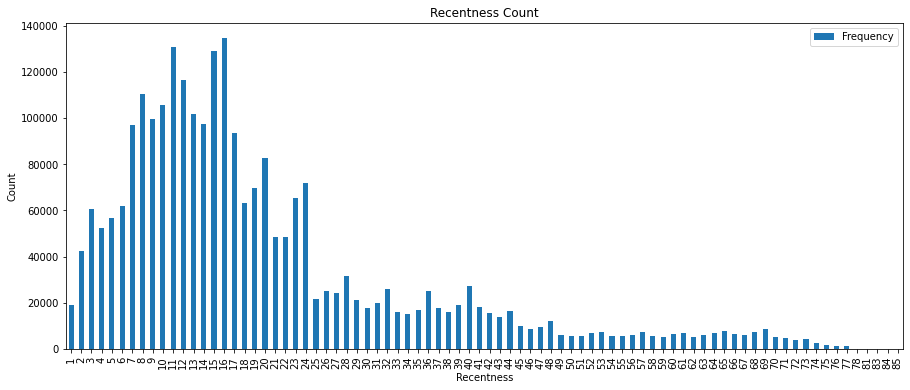

In [24]:
# review recentness
dfRecentness.plot.bar(x='Recentness', y='Frequency', figsize=(15,6), title='Recentness Count', ylabel='Count')

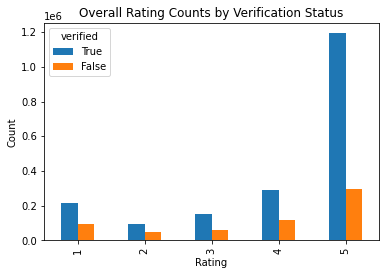

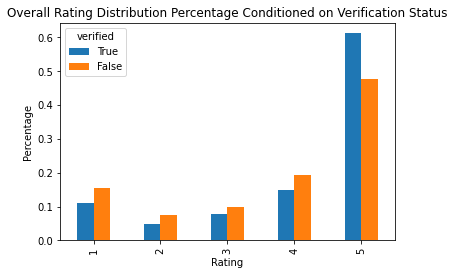

In [105]:
# rating distribution
# dfReviews['rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution',
#                                                      xlabel='Rating', ylabel='Count')

dfRatingsByVerified = dfReviews.groupby('verified', sort=False).rating.value_counts(normalize=False).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Count', title='Overall Rating Counts by Verification Status')

dfRatingsByVerified = dfReviews.groupby('verified', sort=False).rating.value_counts(normalize=True).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Percentage', 
                            title='Overall Rating Distribution Percentage Conditioned on Verification Status')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


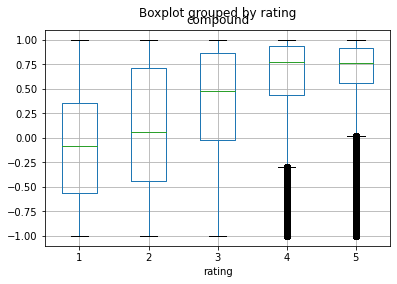

In [44]:
dfReviews.boxplot(column='compound', by='rating')

#### Aggregate Reviews

In [45]:
# get mean rating, total numbers of reviews, and verified reviews per asin
gcAsin = dfReviews.groupby(['asin'], as_index=False).agg({'rating': 'mean', 'reviewerID': 'count', 'verified': 'sum'})
gcAsin = gcAsin.rename(columns={'rating': 'meanRating', 'reviewerID': 'numReviews', 'verified': 'numVerifiedReviews'})

gcAsin['percentageVerifiedReviews'] = gcAsin['numVerifiedReviews'] / gcAsin['numReviews']
# gcAsin = gcAsin.sort_values(by=['numReviews', 'asin'], ascending=[False, True], ignore_index=True)

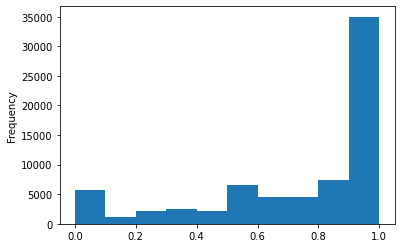

In [46]:
gcAsin['percentageVerifiedReviews'].plot.hist(bins=10)

In [47]:
# get mean rating and total counts per asin per verified
gcAsinVer = dfReviews.groupby(['asin', 'verified'], as_index=False).agg({'rating': 'mean', 'reviewerID': 'count'})
gcAsinVer = gcAsinVer.rename(columns={'rating': 'avgRating', 'reviewerID': 'numReviews'})
gcAsinVer = gcAsinVer.sort_values(by=['numReviews', 'asin', 'verified'], ascending=[False, True, True], ignore_index=True)

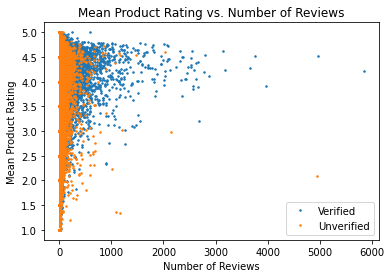

In [48]:
# plot scatterplot of ratings vs. number of reviews per product for verified and unverified reviews respectively
gcVerified = gcAsinVer.loc[gcAsinVer['verified'] == True]
gcUnverified = gcAsinVer.loc[gcAsinVer['verified'] == False]

plt.figure()
plt.plot(gcVerified['numReviews'], gcVerified['avgRating'], '.', markersize=3, label='Verified')
plt.plot(gcUnverified['numReviews'], gcUnverified['avgRating'], '.', markersize=3, label='Unverified')
plt.title('Mean Product Rating vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Mean Product Rating')
plt.legend()
plt.show()

## Aggregate Data

In [105]:
# merge reviews data and metadata together
dfAggr = dfReviews.merge(dfProd, how='inner', on='asin')

In [106]:
dfAggr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1587441 entries, 0 to 1587440
Data columns (total 36 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   asin              1587441 non-null  object        
 1   rating            1587441 non-null  uint8         
 2   verified          1587441 non-null  bool          
 3   reviewTime        1587441 non-null  datetime64[ns]
 4   timeDiff          1587441 non-null  int64         
 5   recentness        1587441 non-null  uint8         
 6   reviewerID        1587441 non-null  object        
 7   reviewText        1586391 non-null  object        
 8   reviewTextLength  1586391 non-null  Int32         
 9   summary           1586978 non-null  object        
 10  summaryLength     1586978 non-null  Int32         
 11  vote              1587441 non-null  Int32         
 12  styleStr          1587441 non-null  object        
 13  numStyles         1587441 non-null  uint8 